In [1]:
"""
Objective: Apply the DNN model to the training set and visualize results 
"""

'\nObjective: Apply the DNN model to the training set and visualize results \n'

In [13]:
import scipy.io
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import keras.backend as K
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras import metrics

import tensorflow as tf
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

In [14]:
#STEP 1: LETS VISUALIZE THE DATASET (ECG FILES)

# Load all the files with .mat extension
dataDir = './training2017/'
files = sorted(glob.glob(dataDir+"*.mat"))
print(f"The total number of ECG files is:{len(files)}")

The total number of ECG files is:8528


In [15]:
f=files[6]
dat = loadmat(f)
print(dat['val'].shape)

(1, 9000)


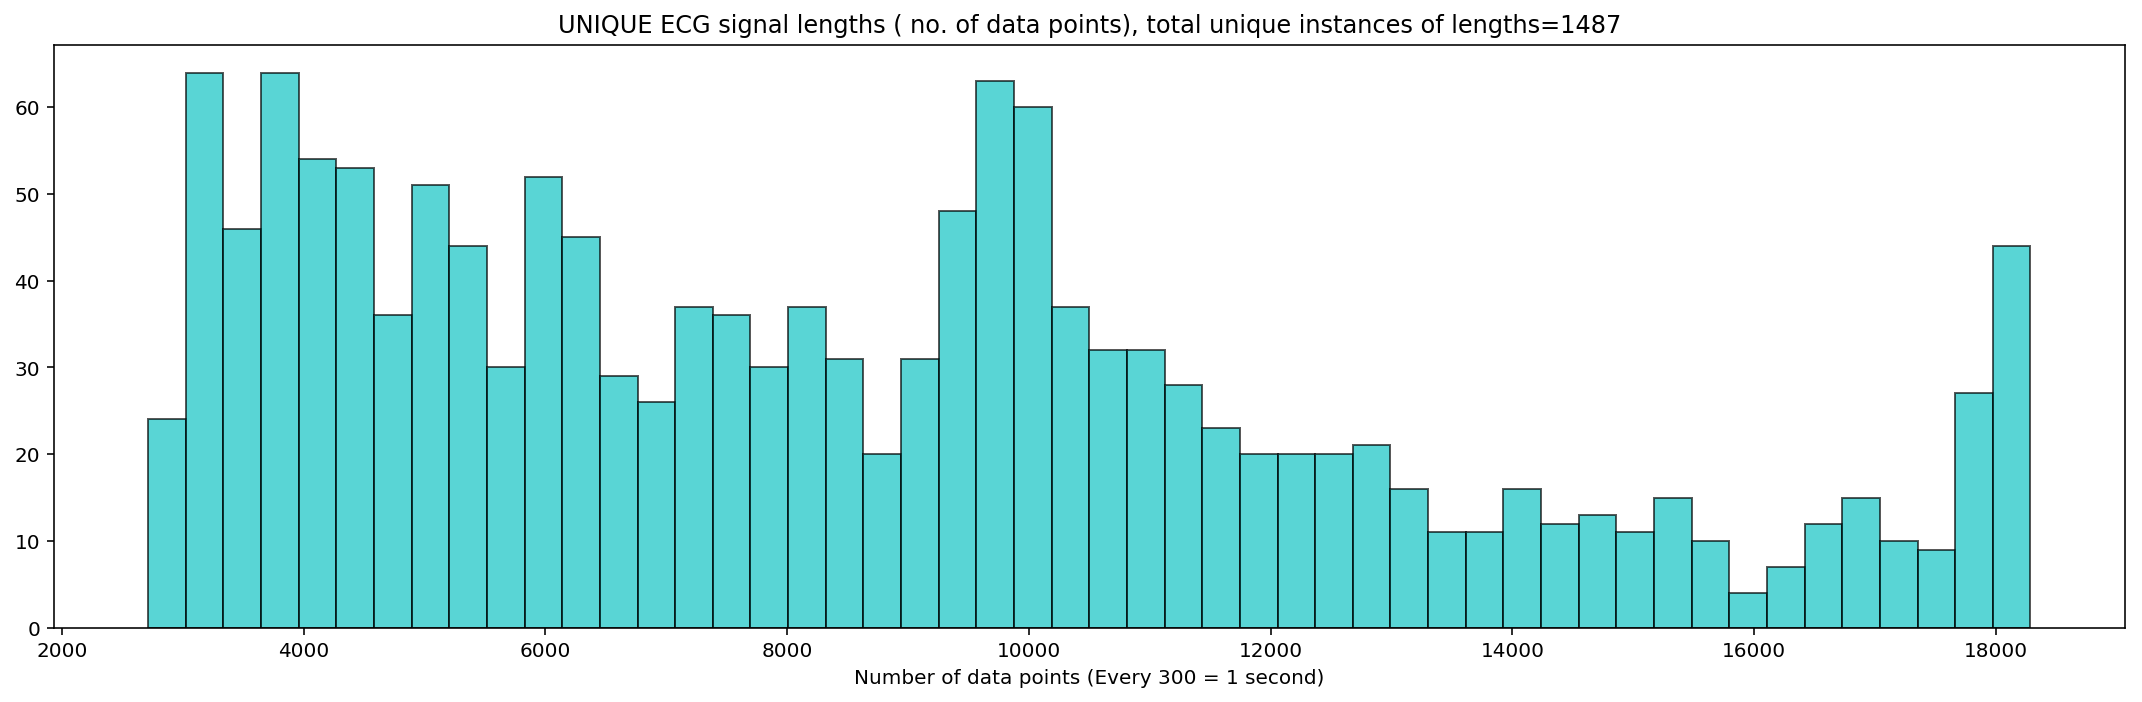

In [4]:
"""
Not all the ECG sizes are same
Here we take a look the the distribution of the ECG lengths in the data

"""
size_list=[]
for i in range(len(files)):
  temp=loadmat(files[i])
  size=len(temp['val'][0])
  size_list.append(size)
unique_sizes = set(size_list)

plt.figure(figsize=(15,5))
plt.hist(sorted(unique_sizes),density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.xlabel('Number of data points (Every 300 = 1 second)')
plt.title('UNIQUE ECG signal lengths ( no. of data points), total unique instances of lengths=' + str(len(unique_sizes)))
plt.tight_layout()
plt.show()

However, most of the data is of length 9000, as seen in histogram below

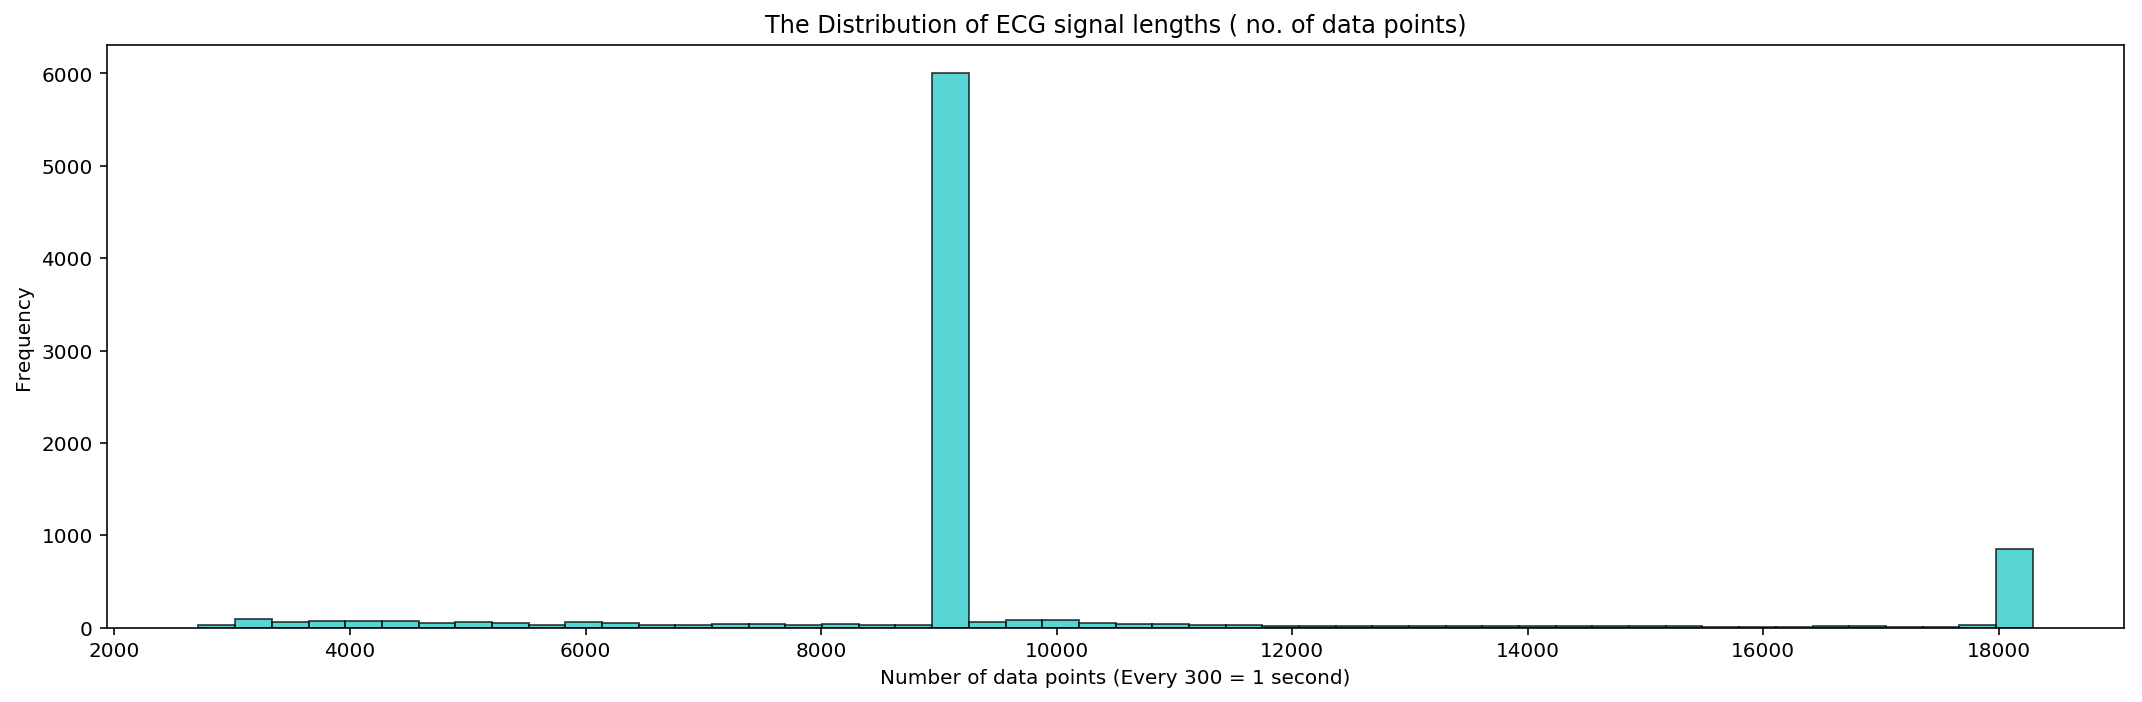

In [5]:
plt.figure(figsize=(15,5))
plt.hist(sorted(size_list),density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.ylabel('Frequency')
plt.xlabel('Number of data points (Every 300 = 1 second)')
plt.title('The Distribution of ECG signal lengths ( no. of data points)')
plt.tight_layout()
plt.show()

In [6]:
"""
How to store all this data in a single numpy file?
Trying to store this in numpy files is futile
access len(val[0]) of the loadmat each time as required
"""

'\nHow to store all this data in a single numpy file?\nTrying to store this in numpy files is futile\naccess len(val[0]) of the loadmat each time as required\n'

In [7]:
# STEP 2: LETS VISUALIZE THE DATA LABELS AND THE DISTRIBUTION

data_labels=pd.read_csv('revised_label.csv', header=None)
print(data_labels.head())
print("...........")

"""
Since we have no header in the labels, header = None
The dataset it is listed as just filename and label
Hence, 8528 data points (entries) are shown, no value is missing
"""

print(f"The shape of labels is{data_labels.shape}")
print("...........")
data_labels.info()

        0  1
0  A00001  N
1  A00002  N
2  A00003  N
3  A00004  A
4  A00005  A
...........
The shape of labels is(8528, 2)
...........
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528 entries, 0 to 8527
Data columns (total 2 columns):
0    8528 non-null object
1    8528 non-null object
dtypes: object(2)
memory usage: 133.3+ KB


Text(0.5, 1.0, 'The distribution of classes in the data')

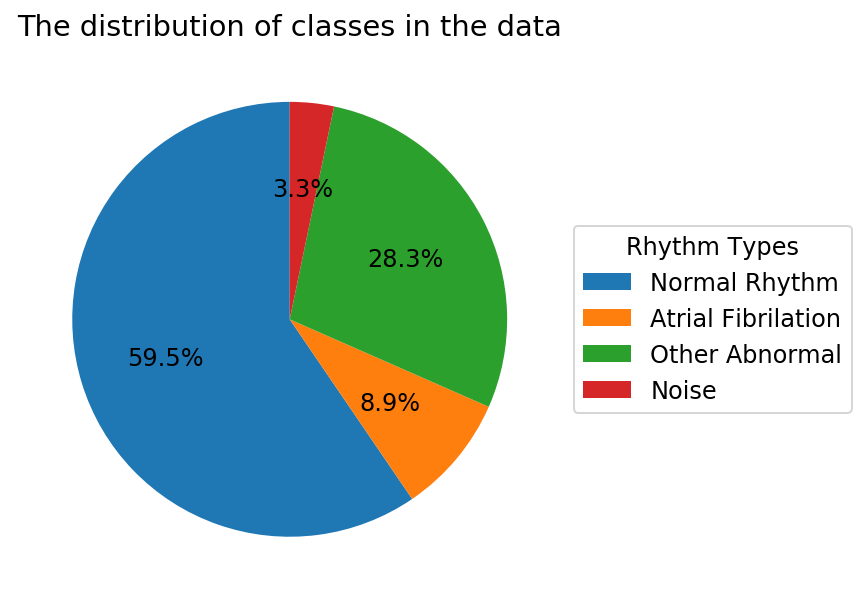

In [8]:
#convert to numpy array
dl_array= data_labels.values

#Normal, AF, Other, Noise
labels=['Normal Rhythm','Atrial Fibrilation','Other Abnormal','Noise']
counts=[0,0,0,0]

for item in dl_array:
    if item[1]=='N':
        counts[0]+=1
    elif item[1]=='A':
        counts[1]+=1
    elif item[1]=='O':
        counts[2]+=1
    else:
        counts[3]+=1
        
plt.rcParams["figure.figsize"] = [5,5]
plt.rcParams["font.size"]= 12
fig1, ax1 = plt.subplots(subplot_kw=dict(aspect="equal"))
ax1.pie(counts, autopct='%1.1f%%', startangle=90)
ax1.legend(labels,title="Rhythm Types",loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax1.set_title("The distribution of classes in the data")

In [9]:
"""
A function to plot the data given an .mat file
Although all the signals are sampled at 300Hz the length of the samples greatly varies
Ideally, The input should have been 30s long 
and sampling frequency of the data is 300Hz so, 
there should have been a total of 9000 data points in each data
each second is to be divided into 300 distinct points
a range would be then defined accordingly, 
by dividing each second into 300 3.33 millisecod intervals
"""

# The input to this function should be the 'files[i]' array of the loadmat loaded input

def plot_ECG(data):
    
    splitted=data.split('/')
    again_splitted=splitted[2].split('.')
    file_name=again_splitted[0]
    label=""
    for item in dl_array:
        if item[0] == file_name:
            label=item[1]
    if label=='N':
        class_name = "Normal Rhythm"
    elif label=='A':
        class_name = "Atrial Fibrilation"
    elif label =='O':
        class_name = "Other Abnormal"
    else: 
        class_name ="Noise"
    
    dat=loadmat(data)
    mat_data= dat['val'][0]
    x_axis = np.linspace(0.,float(len(mat_data)/300),num=len(mat_data))
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(16,5))
    plt.plot(x_axis, mat_data,'r')
    plt.axis([0, len(mat_data)/300,-2200, 2200])
    plt.title(class_name)
    plt.ylabel('milli Volts')
    plt.xlabel('Time (in seconds)')
    plt.tight_layout()
    plt.show()

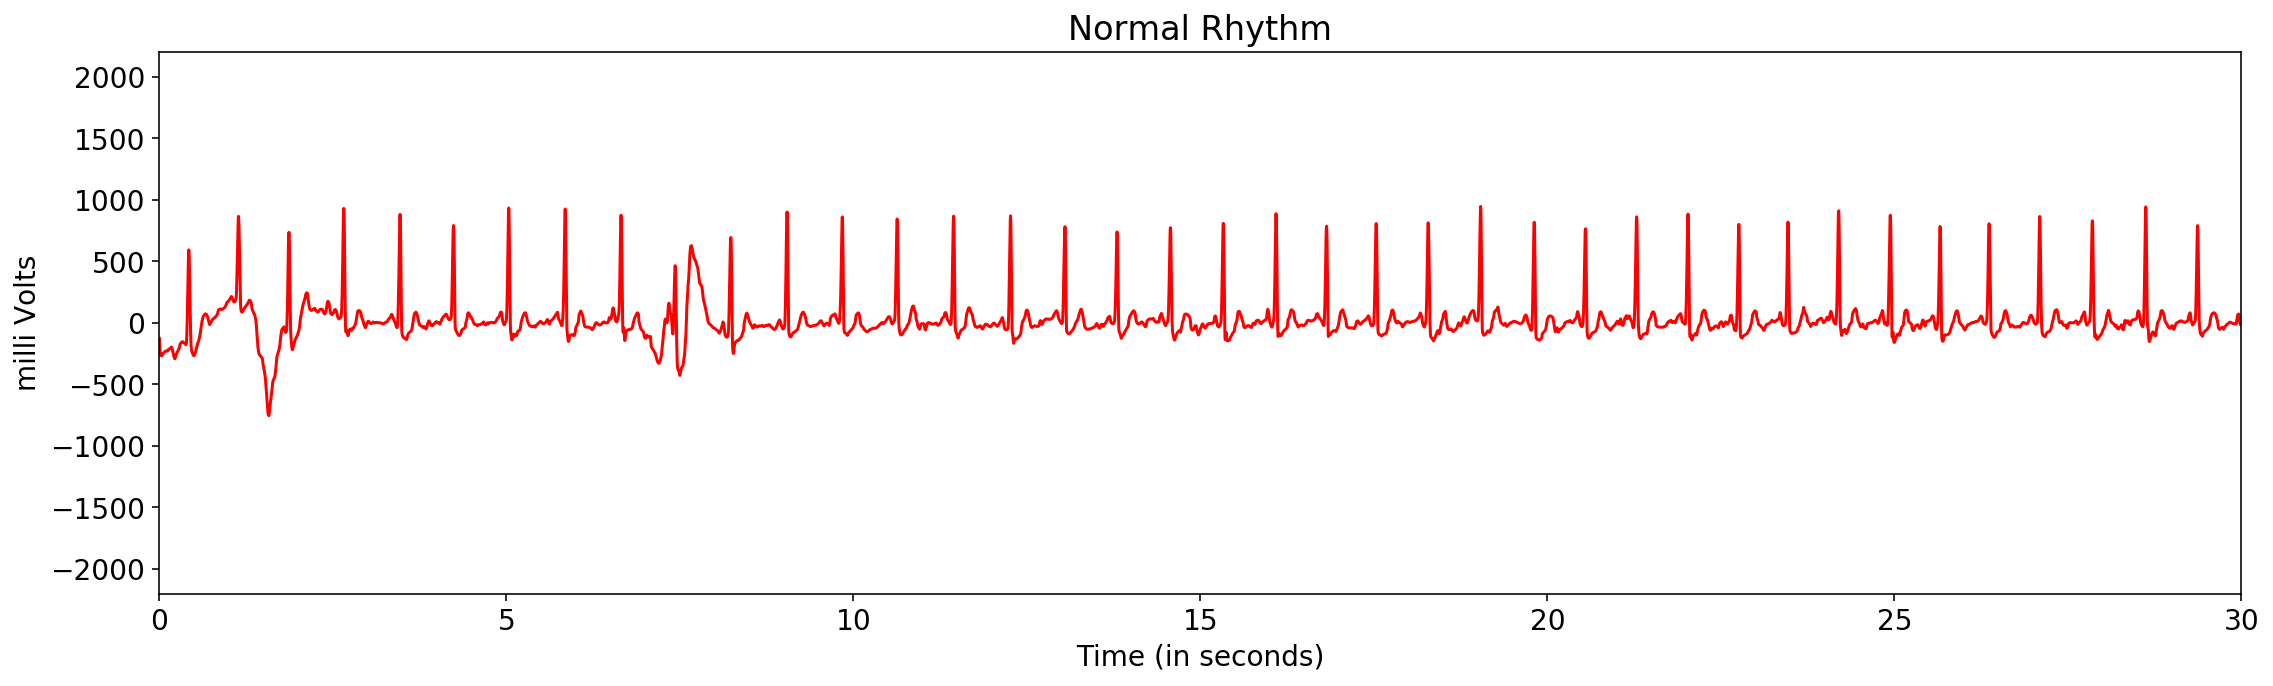

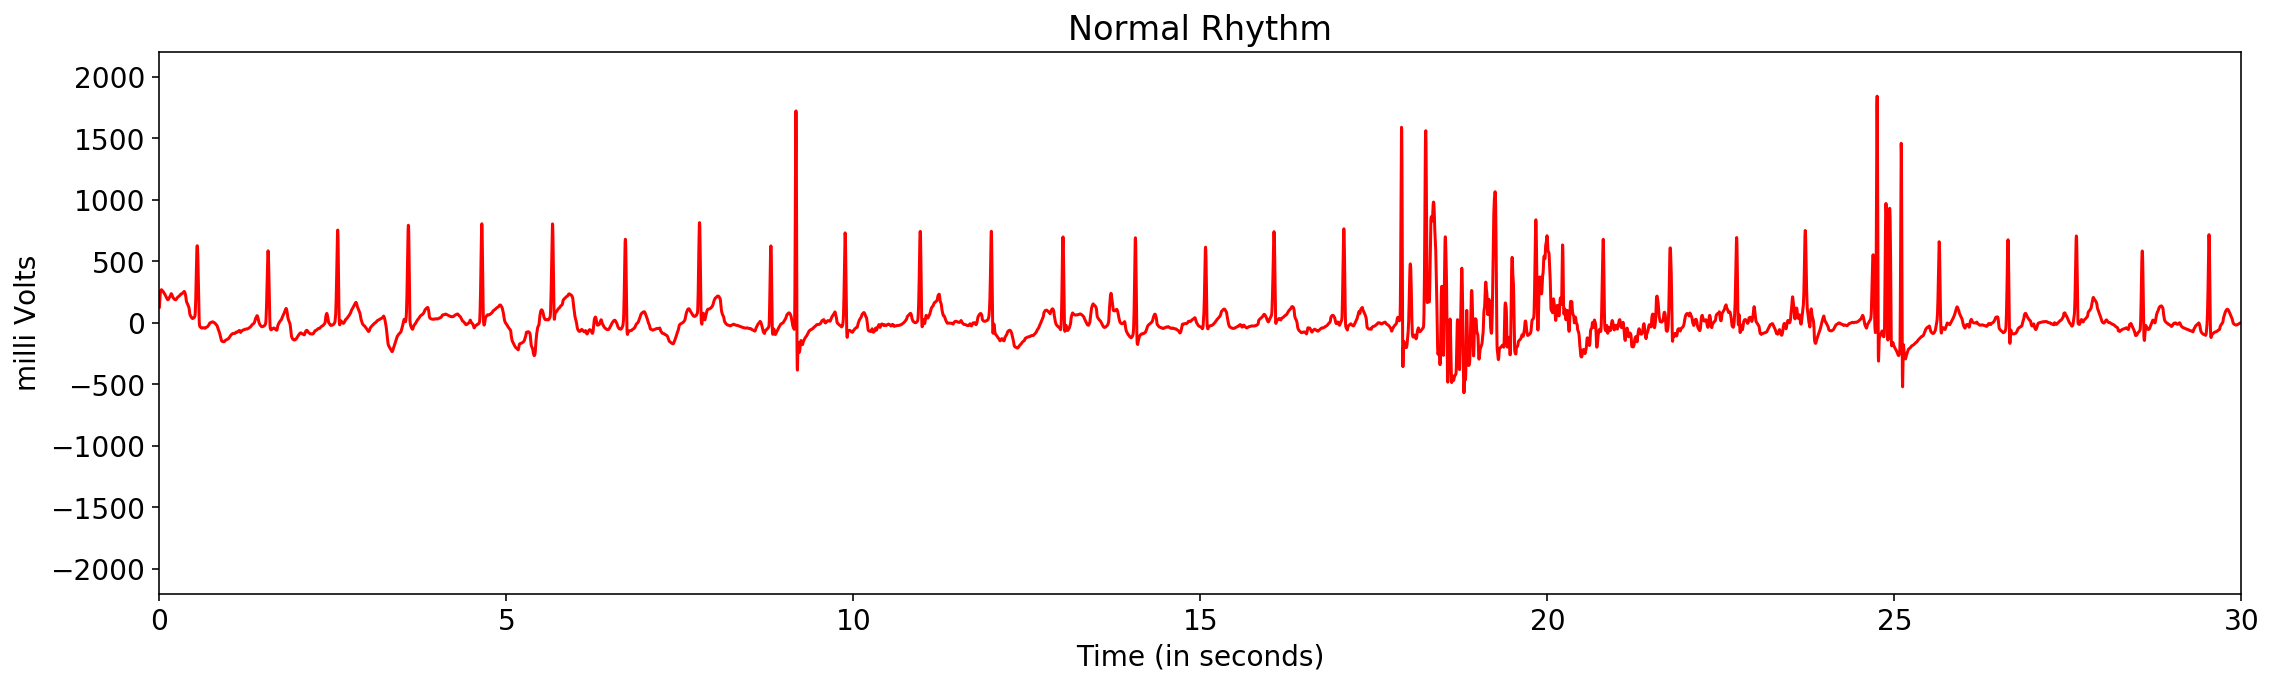

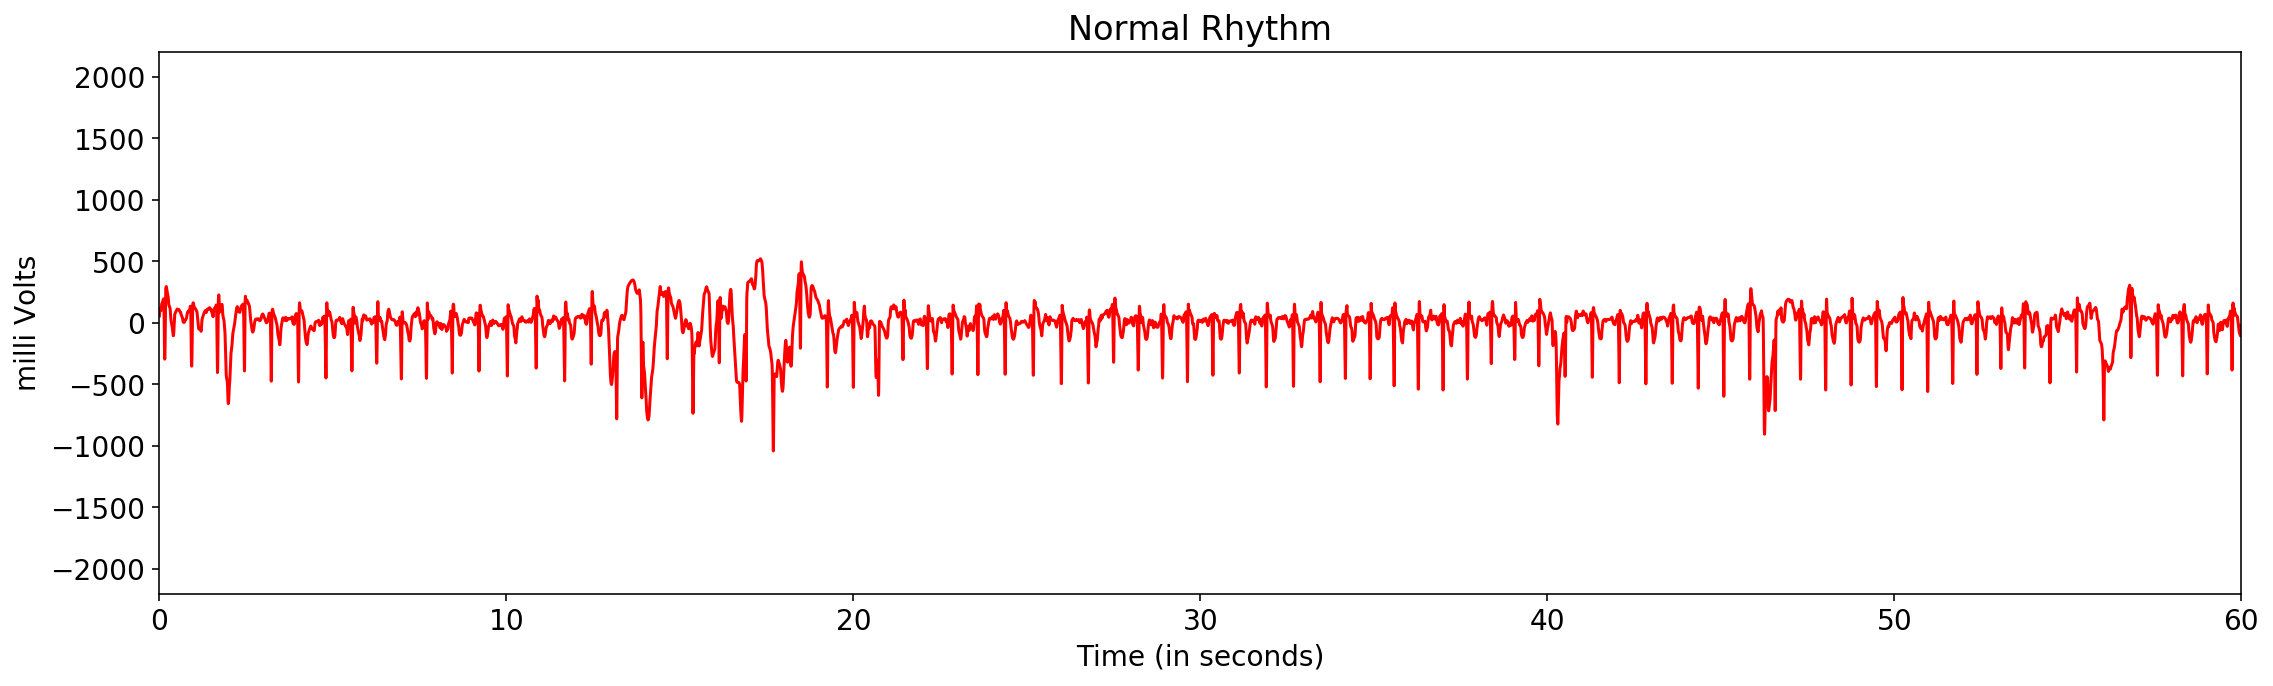

In [10]:

"""
Select 3 random ECG and plot them to visualize using the function above
"""
import random
rand_list = [random.randint(0,8528) for i in range(3)]
for i in range(3):
    plot_ECG(files[i])


In [11]:
#STEP 3: DATA PREPROCESSING/ HELPER FUNCTIONS
"""
Some of the things here may not make sense but it is thier implementation 
I am trying to replicate the results here

1. For  every file they give a constant value of maxlen that is 9000 and clip the data
However, we have seen above that data can be of size upto 18000

2. They make use of data as a 2D array in so many places, however, it is just a 1D array
"""

def preprocess(x, maxlen):
    
    #Replace any 'not a number with a zero and infinity'
    x =  np.nan_to_num(x)
    
    # The value of maxlen is set to 9000 before passing to the function
    # Clip the data at 9000 points, new size of data is 1x9000 if the size of x > 9000
    # But this is adaptive, if the length of x is less than 9000, it retains original size
    # This also converts x from a 2d array to 1d
    x =  x[0, 0:maxlen]
    
    # Standard Scaling (mean and std of this particular data for each)
    x = x - np.mean(x)
    x = x / np.std(x)

    # init a 2D array of size 1x9000
    tmp = np.zeros((1, maxlen))
    
    # copy the contents of x to tmp
    # but tmp here is 2D array
    # what is the meaning of padding sequence?
    tmp[0, :len(x)] = x.T  # padding sequence
    
    # convert x back to 2D array with scaled contents
    x = tmp
    
    # This is the most strange step, they say it is required by keras
    # They convert the scaled x values to a 3D array (axis =2)
    # With values written as [[[0.7],[0.6],[0.4],....]]
    x = np.expand_dims(x, axis=2)  # required by Keras
    
    #delete temp
    del tmp
    
    return x

In [12]:
# Set values of a few constants
FS = 300
WINDOW_SIZE = 30*FS 

def predict_data(model,x):
    
    # The model expects a numpy array as a input (Keras)
    # The output that the predict function returns is a list of probabilities of all 4 classes
    prob = model.predict(x)
    
    # Returns an index of the max value in an array
    ann = np.argmax(prob)
    
    return prob,ann

In [13]:
#STEP 4: Apply the DNN model to the Pre Processed data (Make Predictions)

#Main Loop
#Load files and model

dataDir = './training2017/'
files = sorted(glob.glob(dataDir+"*.mat"))

# Load and apply model

print("Loading model")    
model = load_model('ResNet_30s_34lay_16conv.hdf5')

# load groundTruth
# I have stored it as revised_label.csv instead of REFERENCE-v3.csv
print("Loading ground truth file")   
csvfile = list(csv.reader(open('revised_label.csv')))

# There are 4 classes but why 8528x5 2D array is constructed?
# 0th column = index of ground truth label (index from the classes array below)
# 1st column = index of prediction (max value from the prediction array)
# 2nd column = probability value of the highest probability class
# 3rd column = length of ECG in seconds
# 4th column = the count value of next data
prediction = np.zeros((len(files),5))

# count the number of files processed (progress count)
count = 0

# count the number of predictions that were correct
correct = 0

# The 4 classes
classes = ['A', 'N', 'O','~']

print("Applying Model to Data: This may take a while...")

#Apply model to files
for f in files:
    
    #remove the '.mat' = 4 characters from the file path
    record = f[:-4]
    
    # just take the record name from file path (eg. A00001) has 6 characters
    record = record[-6:]
    
    # Load .mat file to a dictionary
    # I dont know why they do it like this, just loadmat(f) was fine
    mat_data = scipy.io.loadmat(f[:-4] + ".mat")
    
    # Just get the numeric array - using key 'val' from dictionary  
    data = mat_data['val']
    
    # For preprocessing, WINDOW_SIZE is passed as argument, it is a constant of value 9000
    x = preprocess(data, WINDOW_SIZE)
    
    # CSV file has records in the format A00001,N.... get the label of the current file
    ground_truth_label = csvfile[count][1]
    
    # The index of the ground truth label, from the classes array defined above
    ground_truth = classes.index(ground_truth_label)
    
    # Prediction (returns a list of probabilites and the index of max probability)
    prob_x, ann_x = predict_data(model, x)

    # print Record A00001 ground truth: N
    #print("Record {} ground truth: {}".format(record, ground_truth_label))
    
    #print Record A00001 classified as N with 60% certainty
    #print("Record {} classified as {} with {:3.1f}% certainty".format(record, classes[ann_x], 100*prob_x[0,ann_x]))
    
    # index of ground truth label (index from classes array)
    prediction[count,0] = ground_truth
    
    # index of the class with highest predicted probability
    prediction[count,1] = ann_x
    
    # The probability value (not class label) of the correct class
    prediction[count,2] = prob_x[0,ann_x]
    
    # Number of points in each data (when divided by 300 gives the length of ECG in seconds)
    prediction[count,3] = len(data[0,:])/300.0
    
    # Next count value
    prediction[count,4] = count+1
    
    if (ground_truth == ann_x):
        correct += 1
        
    count += 1

# At the end of this loop, all the results are stored in 8528x5 array named prediction   
print("Model Application Complete")

Loading model


Loading ground truth file
Applying Model to Data: This may take a while...


/Users/bibekpoudel/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Model Application Complete


In [14]:
#STEP 5: PRESENT ACCURACY AND STORE RESULTS IN FILE
# Although saving to files seems unnecessary, it may be required later for adversarial examples generation

"""
In the original implementation, 
The data is saved into 4 csv files
"""

print("RESULTS")
print("................")

print("Correct:{}, total:{}".format(correct, count))
print("Hence the accuracy of the model is:{} % ".format(round(correct/(count)*100,2)))
print("................")

# prediction is a 2d array
# cond_x_gt is a 1d array of Ture, False... for each of the predictions
cond_x_gt = np.equal(prediction[:,1], prediction[:,0]) 

# store the entire 5 columns but only for the correct predictions
correct_prediction = prediction[cond_x_gt]

# save correct prediction to csv file
format = '%i,%i,%.5f,%.2f,%i'
np.savetxt("prediction_correct.csv", correct_prediction, fmt= format, delimiter=",")

#save the results of each class to thier own csv file
#since each class has own file, we do not need to save index, so 1 is skipped

type_A = correct_prediction[(correct_prediction[:,0] == 0)]
type_A_select = type_A[:,[0,2,3,4]]
print("Type Atrial Fibliration has {} correct results".format(len(type_A_select)))

type_N = correct_prediction[(correct_prediction[:,0] == 1)]
type_N_select = type_N[:,[0,2,3,4]]
print("Type Normal has {} correct results".format(len(type_N_select)))

type_O = correct_prediction[(correct_prediction[:,0] == 2)]
type_O_select = type_O[:,[0,2,3,4]]
print("Type Other Rhythm has {} correct results".format(len(type_O_select)))

type_i = correct_prediction[(correct_prediction[:,0] == 3)]
type_i_select = type_i[:,[0,2,3,4]]
print("Type noise has {} correct results".format(len(type_i_select)))

np.savetxt('data_select_A.csv', type_A_select, delimiter=",")
np.savetxt('data_select_N.csv', type_N_select, delimiter=",")
np.savetxt('data_select_O.csv', type_O_select, delimiter=",")
np.savetxt('data_select_i.csv', type_i_select, delimiter=",")

print("................")
print("Data storage to csv files complete")

RESULTS
................
Correct:6081, total:8528
Hence the accuracy of the model is:71.31 % 
................
Type Atrial Fibliration has 447 correct results
Type Normal has 3886 correct results
Type Other Rhythm has 1488 correct results
Type noise has 260 correct results
................
Data storage to csv files complete


In [15]:
# STEP 6: RESULTS VISUALIZATION

"""
Some of the results here will be useful for the defense techniques

1. Class wise prediction accuracy (which class is the easiest and hardest to predict?)
2. Histogram of the classification confidence (probability percentage ) for each class correctly classified
3. Histogram of the confidence on misclassified examples
4. Multiclass confusion matrix (what was confused for what the most?)
5. Signal Lengths histogram of correclty and incorrect classicfications 
6. Plots of some of the misclassified signals (lets see them) - NOT important
"""

'\nSome of the results here will be useful for the defense techniques\n\n1. Class wise prediction accuracy (which class is the easiest and hardest to predict?)\n2. Histogram of the classification confidence (probability percentage ) for each class correctly classified\n3. Histogram of the confidence on misclassified examples\n4. Multiclass confusion matrix (what was confused for what the most?)\n5. Signal Lengths histogram of correclty and incorrect classicfications \n6. Plots of some of the misclassified signals (lets see them) - NOT important\n'

class wise pie chart of accuracy for each class


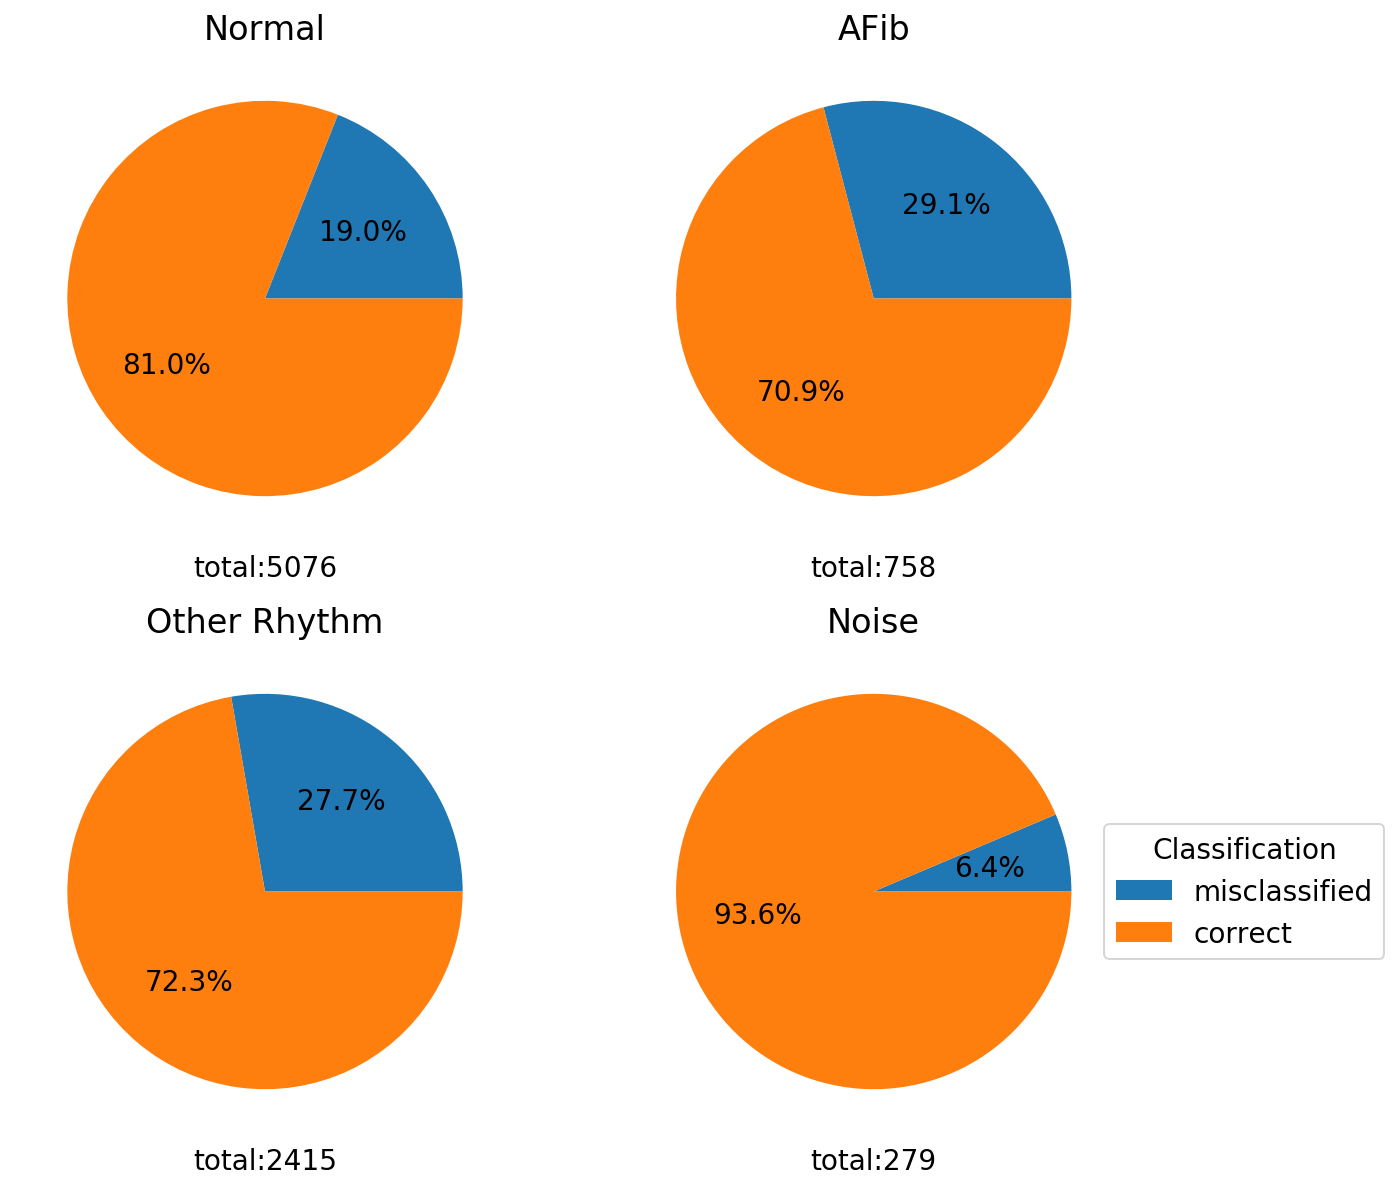

In [16]:
#1.Class wise prediction accuracy (which class is the easiest and hardest to predict?)

#total ground truths that belong to class
class_n_total = len(prediction[(prediction[:,0]==1)])
class_a_total = len(prediction[(prediction[:,0]==0)])
class_o_total = len(prediction[(prediction[:,0]==2)])
class_noise_total = len(prediction[(prediction[:,0]==3)])

#predicted value counts for each class
#These values are correctly predicted (predicted and correctly predicted are different)
# i.e. ground truth (index 0) and prediction are a match
correct_n_count=0
correct_a_count=0
correct_o_count=0
correct_noise_count=0

for pred in prediction: 
    if(pred[0]==1 and pred[1]==1):
        correct_n_count+=1
    elif(pred[0]==0 and pred[1]==0):
        correct_a_count+=1
    elif(pred[0]==2 and pred[1]==2):
        correct_o_count+=1
    elif(pred[0]==3 and pred[1]==3):
        correct_noise_count+=1
        
#missed values
missed_n= class_n_total - correct_n_count
missed_a= class_a_total - correct_a_count
missed_o= class_o_total - correct_o_count
missed_noise= class_noise_total - correct_noise_count

print("class wise pie chart of accuracy for each class")
labels_2=['misclassified','correct']
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie([missed_n,class_n_total],autopct='%1.1f%%')
plt.xlabel("total:"+str(class_n_total))
plt.title('Normal')

ax1 = plt.subplot2grid((2,2),(0,1))
plt.pie([missed_a,class_a_total],autopct='%1.1f%%')
plt.xlabel("total:"+str(class_a_total))
plt.title('AFib')

ax1 = plt.subplot2grid((2,2),(1,0))
plt.pie([missed_o,class_o_total],autopct='%1.1f%%')
plt.xlabel("total:"+str(class_o_total))
plt.title('Other Rhythm')

ax1 = plt.subplot2grid((2,2),(1,1))
plt.pie([missed_noise,class_noise_total],autopct='%1.1f%%')
plt.xlabel("total:"+str(class_noise_total))
plt.title('Noise')


ax1.legend(labels_2,title="Classification",loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


Hence we can infer than Afib is the most difficult to recognize and noise is the easiest

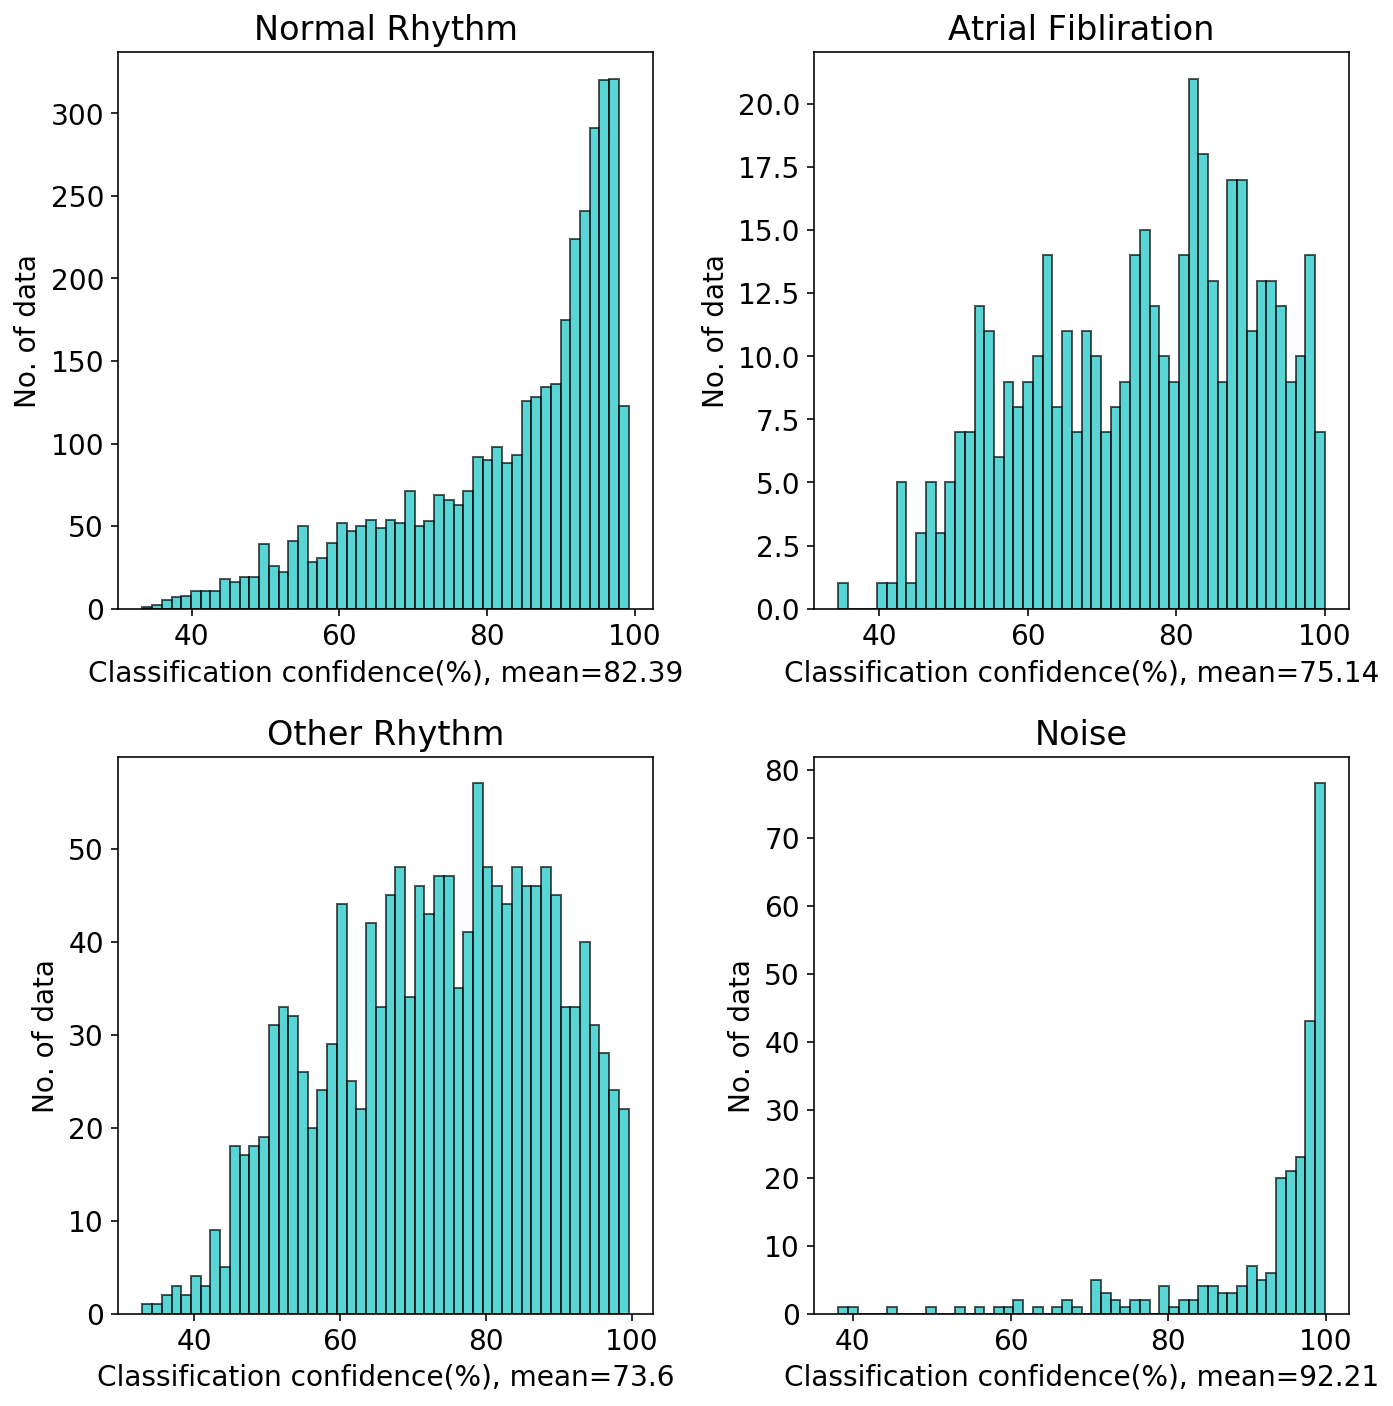

In [17]:
#2. Histogram of the classification confidence (probability percentage ) for each class correctly classified

pred_n=[]
pred_a=[]
pred_o=[]
pred_noise=[]

for pred in prediction: 
    if(pred[0]==1 and pred[1]==1):
        pred_n.append(pred[2])
    elif(pred[0]==0 and pred[1]==0):
        pred_a.append(pred[2])
    elif(pred[0]==2 and pred[1]==2):
        pred_o.append(pred[2])
    elif(pred[0]==3 and pred[1]==3):
        pred_noise.append(pred[2])
    
pred_n=np.round(np.sort(np.asarray(pred_n))*100,2)
pred_a=np.round(np.sort(np.asarray(pred_a))*100,2)
pred_o=np.round(np.sort(np.asarray(pred_o))*100,2)
pred_noise=np.round(np.sort(np.asarray(pred_noise))*100,2)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,2),(0,0))
plt.hist(pred_n,density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.title("Normal Rhythm")
plt.ylabel('No. of data')
plt.xlabel(f'Classification confidence(%), mean={round(np.mean(pred_n),2)}')

ax1 = plt.subplot2grid((2,2),(0,1))
plt.hist(pred_a,density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.title("Atrial Fibliration")
plt.ylabel('No. of data')
plt.xlabel(f'Classification confidence(%), mean={round(np.mean(pred_a),2)}')

ax1 = plt.subplot2grid((2,2),(1,0))
plt.hist(pred_o,density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.title("Other Rhythm")
plt.ylabel('No. of data')
plt.xlabel(f'Classification confidence(%), mean={round(np.mean(pred_o),2)}')

ax1 = plt.subplot2grid((2,2),(1,1))
plt.hist(pred_noise,density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.title("Noise")
plt.ylabel('No. of data')
plt.xlabel(f'Classification confidence(%), mean={round(np.mean(pred_noise),2)}')

plt.tight_layout()
plt.show()


Hence For the correctly classified instances, we can infer that, noise and normal rhythm have more data that are higher condifence. But, Atrial Fibrilation and Other Rhythm have more sparse data.

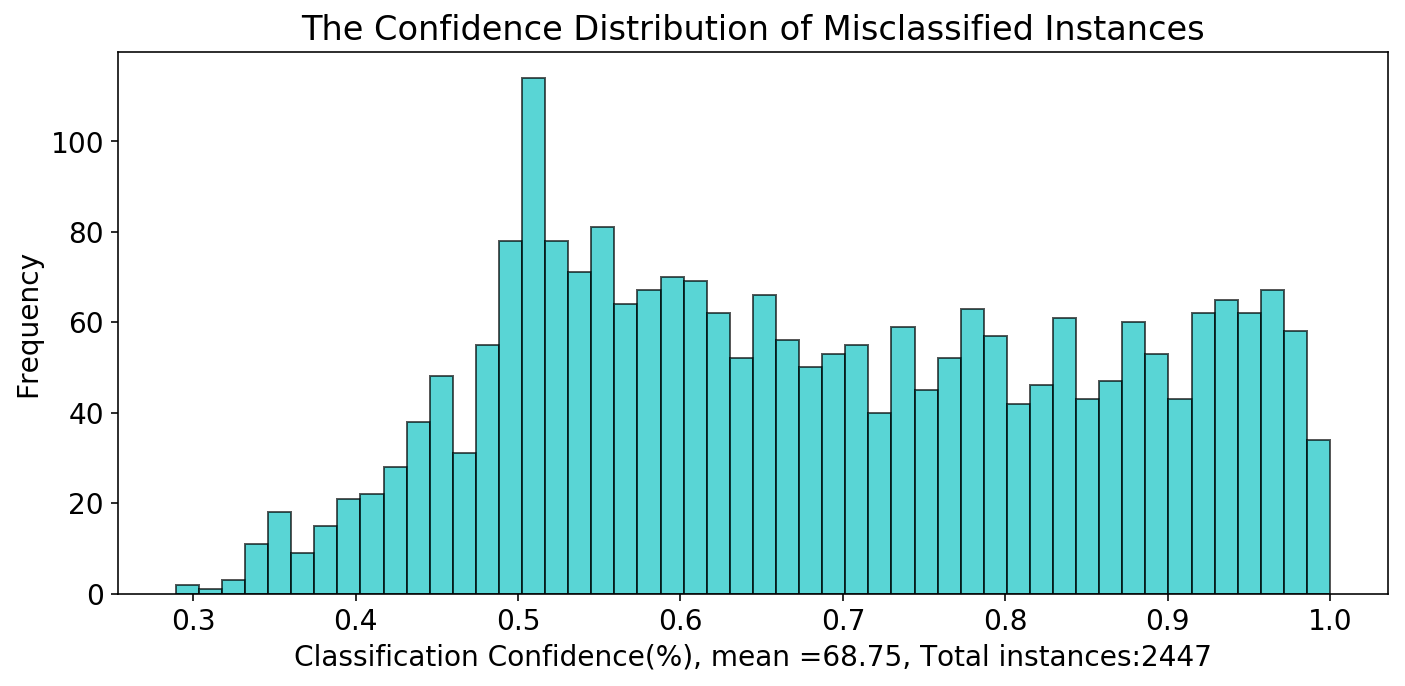

In [18]:
#3. Histogram of the confidence on misclassified examples

"""
There are multiple ways to do it, 
one approach is to plot the histogram of all the data points that were misclassified (regardless of the class)
other approach is to see for each class, what is the distribution of confidence of false positives
we will first one
"""

mispred_no_class=[]
for pred in prediction: 
    ground_truth=pred[0]
    predicted = pred[1]
    if(ground_truth!= predicted):
        mispred_no_class.append(pred[2])
        
mispred_no_class = np.sort(np.asarray(mispred_no_class))     
plt.figure(figsize=(10,5))
plt.hist(mispred_no_class,density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.ylabel('Frequency')
plt.xlabel('Classification Confidence(%), mean ='+str(round(np.mean(mispred_no_class)*100,2))+ ", Total instances:" +str(len(mispred_no_class)))
plt.title('The Confidence Distribution of Misclassified Instances')
plt.tight_layout()
plt.show()

It is observed that, mean classification confidence of misclassified instances is at 68.75%. This is lower than the all the classes that were correclty classified (as seen above) 

Confusion matrix, without normalization
[[ 447   18  204   89]
 [  23 3886  504  663]
 [ 162  468 1488  297]
 [   3    3   13  260]]
Normalized confusion matrix
[[0.59 0.02 0.27 0.12]
 [0.   0.77 0.1  0.13]
 [0.07 0.19 0.62 0.12]
 [0.01 0.01 0.05 0.93]]


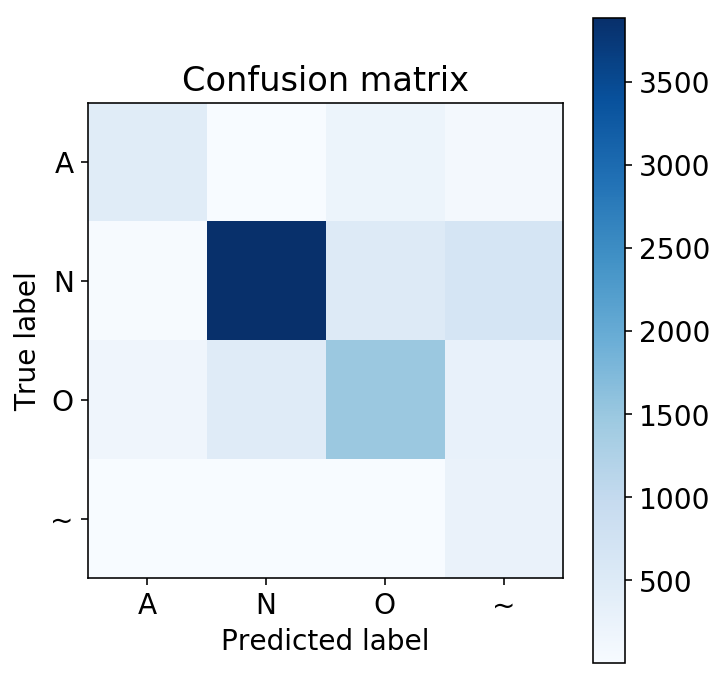

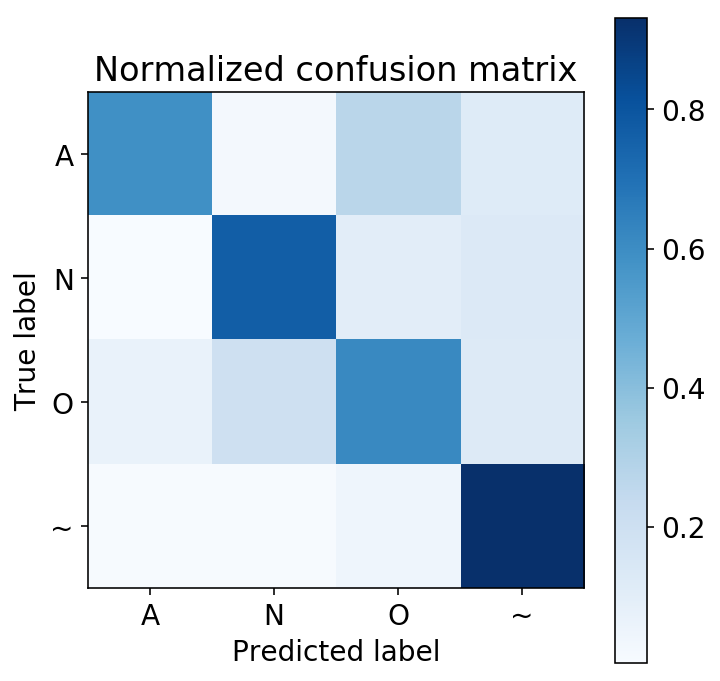

In [19]:
#4. Multiclass confusion matrix (what was confused for what the most?)

"""
Is the multiclass, f1 score, precision and recall any useful here?
"""

ground_truth = prediction[:,0]
predictions = prediction[:,1]

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cm = confusion_matrix(ground_truth, predictions)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

plt.figure()
fig.set_figheight(3)
fig.set_figwidth(3)
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
fig.set_figheight(3)
fig.set_figwidth(3)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

From the Confusion matrix, following observations are made: 
- Noise is most likely to be predicted correctly
- Atrial Fibrilation is most likely to be predicted as Other rhythm/ misclassified (0.27)
- Other rhythm being mis classified as Normal is also likely (0.19)
- Slightly less likely are: all 3 types of rhythms being misclassified as noise (0.12, 0.13)

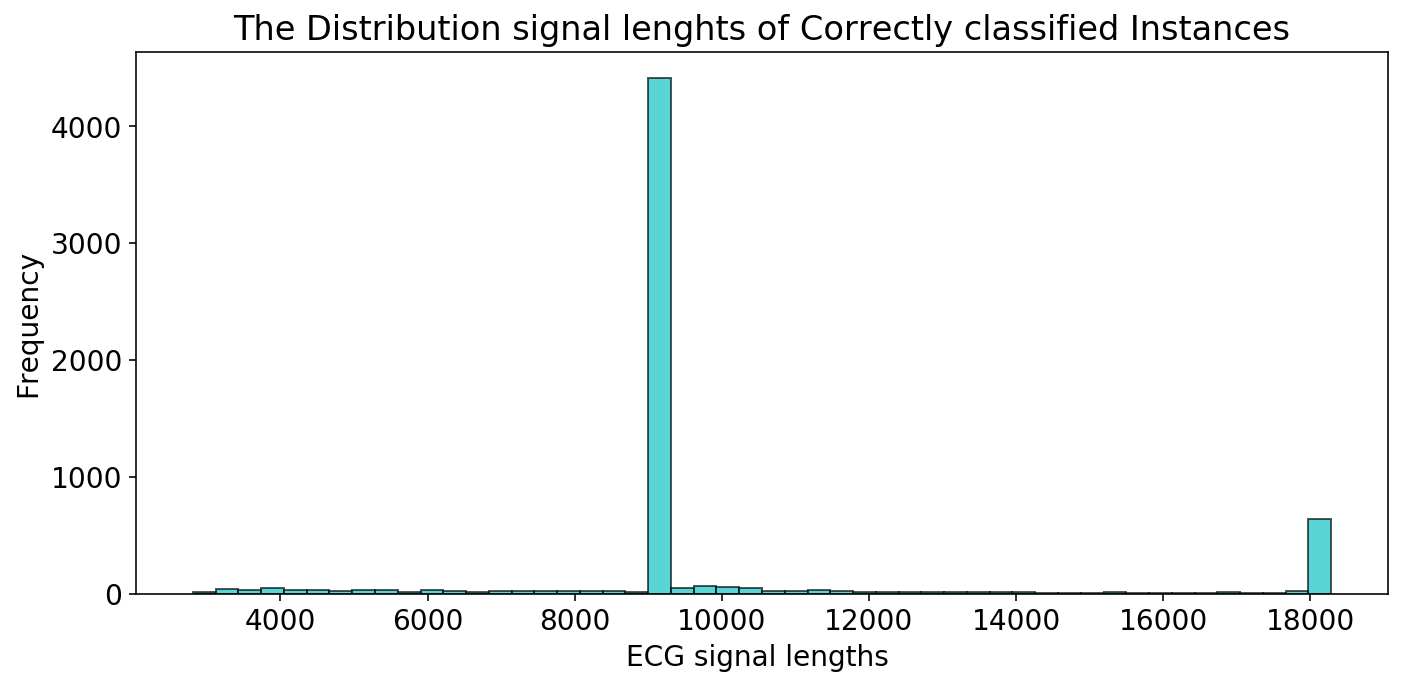

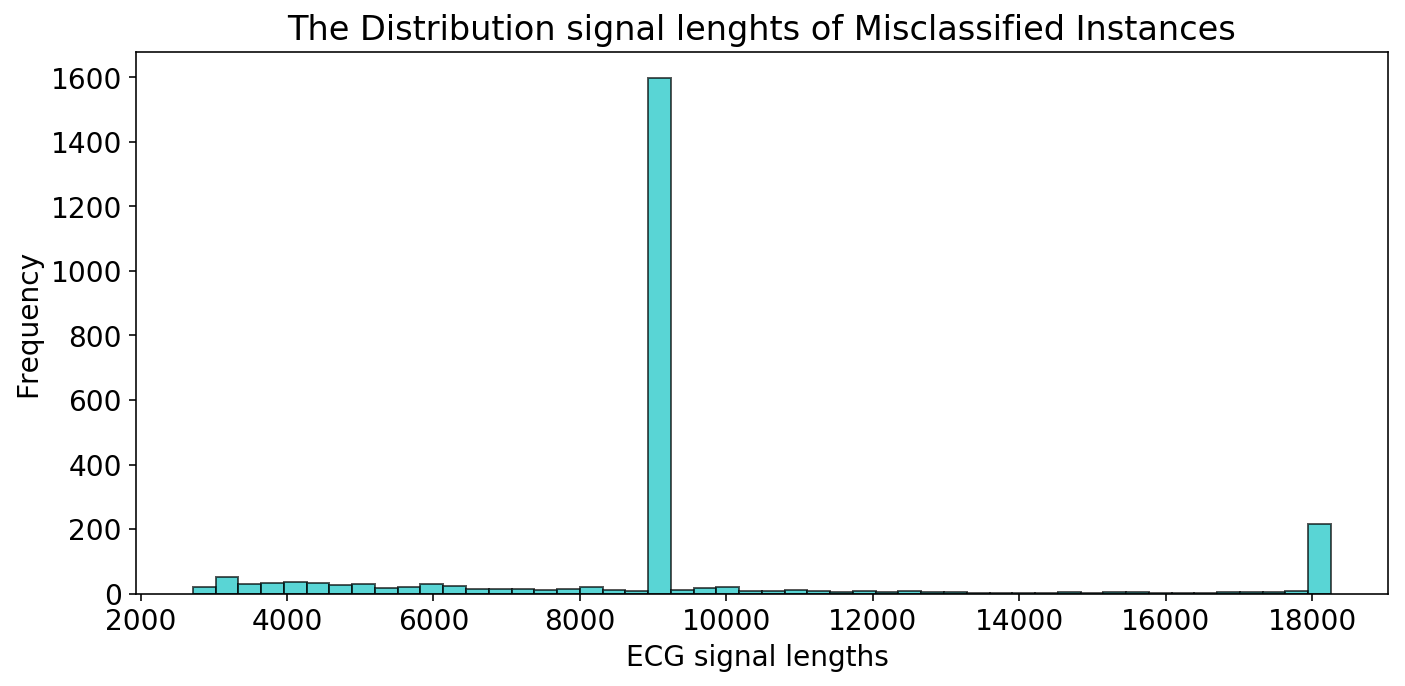

In [20]:
#5. Signal Lengths histogram of correclty and incorrect classicfications 

"""
As given in the paper, what is the exact reference of WINDOW size?
"""
#extracting record number from predictions
misclassified_indices=[]
for pred in prediction:
    if (pred[0]!=pred[1]):
        misclassified_indices.append(int(pred[4]))
        
#extracting record number from files and taking length
mis_lengths_1=[]
for file in files:
    name_1=file.split('/')
    name_2=name_1[2].split('.')
    name_3=name_2[0][1:6]
    name_4=int(name_3)
    if name_4 not in misclassified_indices:
        data=loadmat(file)
        #print(data['val'][0])
        mis_lengths_1.append(len(data['val'][0]))

plt.figure(figsize=(10,5))
plt.hist(mis_lengths_1,density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.ylabel('Frequency')
plt.xlabel('ECG signal lengths ')
plt.title('The Distribution signal lenghts of Correctly classified Instances')
plt.tight_layout()
plt.show()
             
#extracting record number from files and taking length
mis_lengths=[]
for file in files:
    name_1=file.split('/')
    name_2=name_1[2].split('.')
    name_3=name_2[0][1:6]
    name_4=int(name_3)
    if name_4 in misclassified_indices:
        data=loadmat(file)
        #print(data['val'][0])
        mis_lengths.append(len(data['val'][0]))

plt.figure(figsize=(10,5))
plt.hist(mis_lengths,density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.ylabel('Frequency')
plt.xlabel('ECG signal lengths ')
plt.title('The Distribution signal lenghts of Misclassified Instances')
plt.tight_layout()
plt.show()

Here every 300 data points= 1 sec. So, 9000 = 30sec and 18000 = 60 sec

It is no surprise that the signal length distribution is similar to the true data distribution for both correctly classified and misclassified instances of data

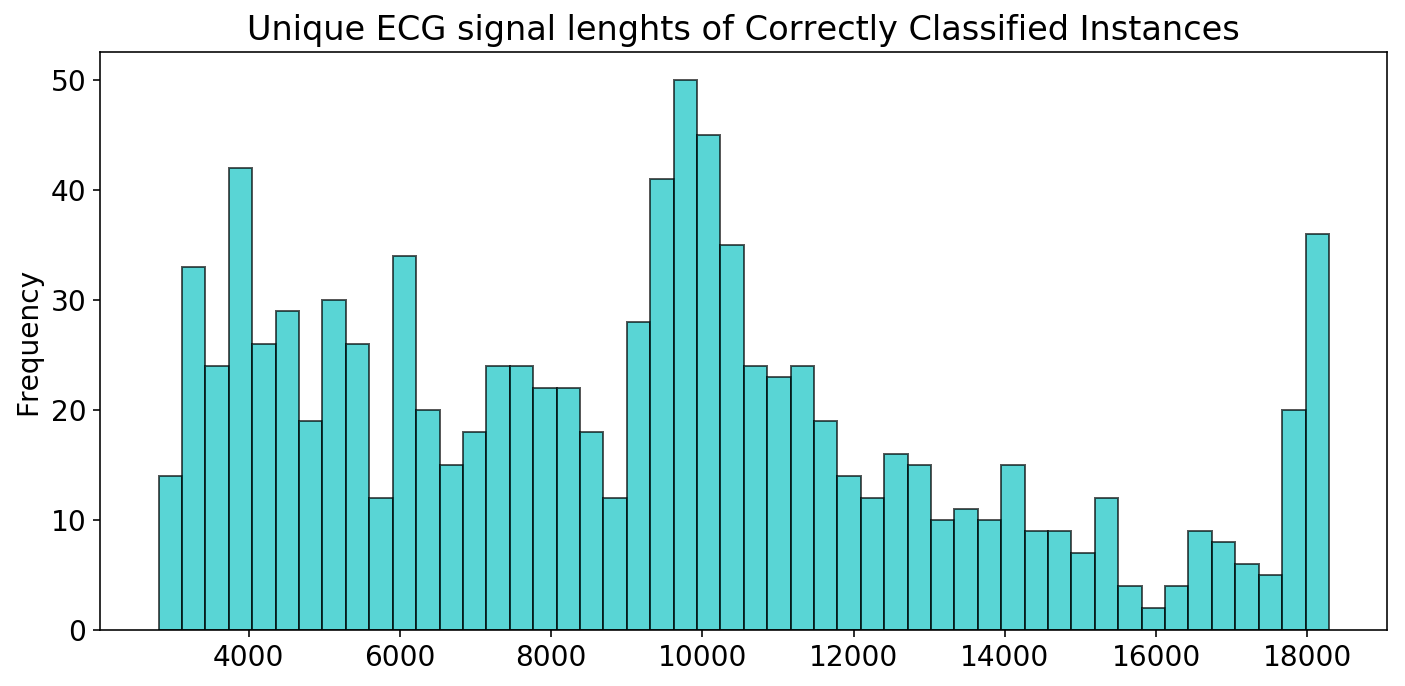

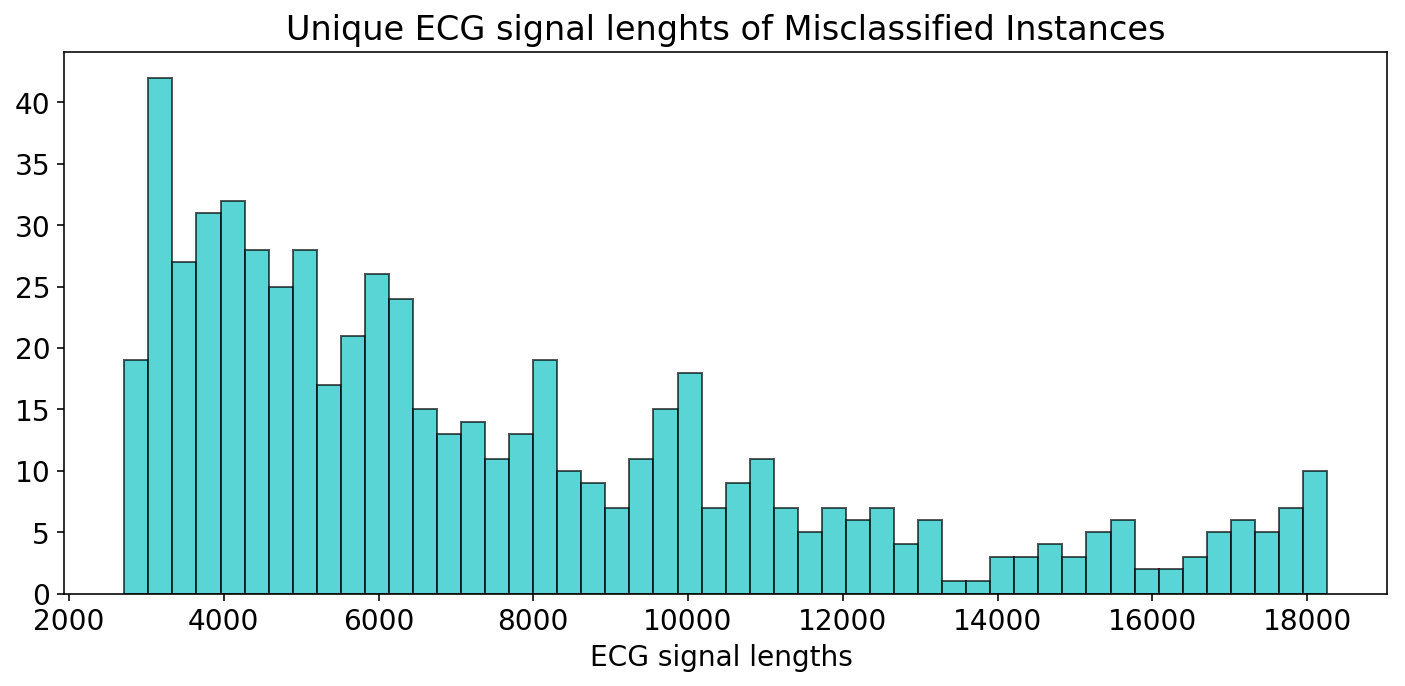

In [24]:
unique_sizes_correct = set(mis_lengths_1)
unique_sizes_incorrect = set(mis_lengths)

plt.figure(figsize=(10,5))
plt.hist(sorted(unique_sizes_correct),density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.ylabel('Frequency')
plt.title('Unique ECG signal lenghts of Correctly Classified Instances')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.hist(sorted(unique_sizes_incorrect),density=False, bins = 50,color='c', edgecolor='k', alpha=0.65)
plt.xlabel('ECG signal lengths ')
plt.title('Unique ECG signal lenghts of Misclassified Instances')
plt.tight_layout()
plt.show()

It seems like, Misclassified instances have higher number of short signals. But that difference is insignificant. A seen in the true length distribution of data (as seen in plot above this). i.e. most data is of length 9000 and 18000 regardless of how it was classifeid.

ANOTHER IMPORTANT ISSUE: All the data are clipped at 9000 (fixed Window size) may be model was trained in such a way that it can only accept input at 9000 or less data points. Hence, the study of signal length variation seems insignificant